### Sample program to create embeddings using 'gensim'

<!-- ```py
from gensim.models import Word2Vec

# Sample sentences
sentences = [
    ['this', 'is', 'a', 'sample', 'sentence'],
    ['another', 'example', 'sentence'],
    ['yet', 'another', 'sentence'],
    ['one', 'more', 'example'],
    ['one', 'more', 'examples'],
]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=100, min_count=1, workers=4)

# Get the embedding vector for a word
word_embedding = model.wv['examples']
print("Embedding for 'examples':", word_embedding[:4])

# Find similar words
similar_words = model.wv.most_similar('example', topn=3)
print("Similar words to 'example':", similar_words)

model.wv.key_to_index.keys()
``` -->

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [2]:
# Creating random data with there embedings

import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from faker import Faker

dummy_data_genrator = Faker()
data_volume = 1_000

In [3]:
payload_data = []

for r in range(data_volume):
    payload_data.append(
        {
            "name":dummy_data_genrator.name(),
            "address":dummy_data_genrator.address(),
            "country":dummy_data_genrator.country(),
            "url":dummy_data_genrator.url(),
            "year":dummy_data_genrator.year(),
            "color":dummy_data_genrator.color()
        }
    )

In [4]:
df = pd.DataFrame(payload_data)
df.head(2)

,name,address,country,url,year,color
0,Angel Douglas,"08993 Hendrix Ways Apt. 402\nMartintown, PA 59699",San Marino,http://www.larson.com/,2019,#998eed
1,Lynn Patterson,"716 Shannon Club Suite 773\nEast Kelly, FL 98700",United States Minor Outlying Islands,http://www.raymond.com/,1976,#c19a22


In [5]:
extracted_country_data = [[data['country'], data['year']] for index, data in df.iterrows()]
extracted_country_data[:3]

[['San Marino', '2019'],
 ['United States Minor Outlying Islands', '1976'],
 ['Wallis and Futuna', '2007']]

In [6]:
# Train Word2Vec model
# Adjust parameters like vector_size (dimensionality of the embeddings), window (context window size), and min_count (minimum frequency of words) based on your dataset and requirements.
# Use meaningful variable names for better readability and maintainability.
vector_size = 100  # Dimensionality of the embeddings
window = 5  # Context window size
min_count = 1  # Minimum frequency of words
workers = 4  # Number of worker threads to train the model
model = Word2Vec(extracted_country_data, vector_size=vector_size, window=window, min_count=min_count, workers=workers)

2024-03-20 22:32:06,889 : INFO : collecting all words and their counts
2024-03-20 22:32:06,890 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-20 22:32:06,892 : INFO : collected 291 word types from a corpus of 2000 raw words and 1000 sentences
2024-03-20 22:32:06,893 : INFO : Creating a fresh vocabulary
2024-03-20 22:32:06,897 : DEBUG : starting a new internal lifecycle event log for Word2Vec
2024-03-20 22:32:06,898 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 291 unique words (100.00% of original 291, drops 0)', 'datetime': '2024-03-20T22:32:06.897469', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
2024-03-20 22:32:06,899 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2000 word corpus (100.00% of original 2000, drops 0)', 'datetime': '2024-03-20T22:32:06.899465', 'ge

In [7]:
# Get keys (words) from the Word2Vec model
list(model.wv.key_to_index.keys())[:3]

['1988', '1970', '1985']

In [8]:
# Get embeddings for each user
country_embeddings = []
year_embeddings = []
for idx, row in df.iterrows():
    country = row['country']
    year = row['year']
    country_embeddings.append(model.wv[str(country)])
    year_embeddings.append(model.wv[str(year)])
country_embeddings[1][:2], year_embeddings[1][:2]


(array([-0.00295571,  0.00201463], dtype=float32),
 array([0.00954947, 0.00739194], dtype=float32))

In [9]:
len(country_embeddings), len(year_embeddings), len(payload_data)

(1000, 1000, 1000)

### Storing embeddings in vector database

In [10]:
from utilities import get_key

from qdrant_client import QdrantClient
from qdrant_client.http import models

client = QdrantClient(
    url=get_key("QDRANT_URL"),
    api_key=get_key("QDRANT_KEY"),
)
client

2024-03-20 22:32:17,982 : DEBUG : load_ssl_context verify=True cert=None trust_env=True http2=False
2024-03-20 22:32:17,988 : DEBUG : load_verify_locations capath='c:\\Users\\satya\\.vscode\\extensions\\ukoloff.win-ca-3.5.1\\node_modules\\win-ca\\pem'


In [11]:
country_collection_name = "test_collection_country"
year_collection_name = "test_collection_year"
index = list(range(data_volume))
country_collection_name,year_collection_name, index[:3], len(index)

('test_collection_country', 'test_collection_year', [0, 1, 2], 1000)

In [12]:
try:
    client.create_collection(
        collection_name=year_collection_name,
        vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
    )
    client.create_collection(
        collection_name=country_collection_name,
        vectors_config=models.VectorParams(size=100, distance=models.Distance.COSINE)
    )
except Exception as ex:
    print(ex)

2024-03-20 22:32:23,529 : DEBUG : connect_tcp.started host='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' port=6333 local_address=None timeout=5.0 socket_options=None
2024-03-20 22:32:23,812 : DEBUG : connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001CC1EA16D90>
2024-03-20 22:32:23,813 : DEBUG : start_tls.started ssl_context=<ssl.SSLContext object at 0x000001CC1FAF8710> server_hostname='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' timeout=5.0
2024-03-20 22:32:24,082 : DEBUG : start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001CC1EB21D50>
2024-03-20 22:32:24,083 : DEBUG : send_request_headers.started request=<Request [b'PUT']>
2024-03-20 22:32:24,084 : DEBUG : send_request_headers.complete
2024-03-20 22:32:24,086 : DEBUG : send_request_body.started request=<Request [b'PUT']>
2024-03-20 22:32:24,088 : DEBUG : send_request_body.complete
2024-03-20 22:32:24,089 : DEBUG : 

In [13]:
client.upsert(
    collection_name=country_collection_name,
    points=models.Batch(
        ids=index,
        vectors=country_embeddings, # Include both sets of embeddings
        payloads=payload_data
    )
)

client.upsert(
    collection_name=year_collection_name,
    points=models.Batch(
        ids=index,
        vectors=year_embeddings, # Include both sets of embeddings
        payloads=payload_data
    )
)

2024-03-20 22:32:28,333 : DEBUG : send_request_headers.started request=<Request [b'PUT']>
2024-03-20 22:32:28,335 : DEBUG : send_request_headers.complete
2024-03-20 22:32:28,336 : DEBUG : send_request_body.started request=<Request [b'PUT']>
2024-03-20 22:32:30,180 : DEBUG : send_request_body.complete
2024-03-20 22:32:30,181 : DEBUG : receive_response_headers.started request=<Request [b'PUT']>
2024-03-20 22:32:31,051 : DEBUG : receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Encoding', b'gzip'), (b'Content-Type', b'application/json'), (b'Date', b'Wed, 20 Mar 2024 17:02:30 GMT'), (b'Vary', b'accept-encoding, Origin, Access-Control-Request-Method, Access-Control-Request-Headers'), (b'Transfer-Encoding', b'chunked')])
2024-03-20 22:32:31,053 : INFO : HTTP Request: PUT https://b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io:6333/collections/test_collection_country/points?wait=true "HTTP/1.1 200 OK"
2024-03-20 22:32:31,054 : DEBUG : rec

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

### Recommend people location of other based on the location and year

In [17]:
same_year_recommends = client.recommend(
    collection_name=year_collection_name,
    positive=[1], # index of similar pattern
    # negative=[75,40], # negitive index
    limit=200
)

same_country_recommends = client.recommend(
    collection_name=country_collection_name,
    positive=[1], # index of similar pattern
    # negative=[75,40], # negitive index
    limit=200
)

2024-03-20 22:47:28,949 : DEBUG : close.started
2024-03-20 22:47:28,952 : DEBUG : close.complete
2024-03-20 22:47:28,953 : DEBUG : connect_tcp.started host='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' port=6333 local_address=None timeout=5.0 socket_options=None
2024-03-20 22:47:29,243 : DEBUG : connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001CC1EA1AAD0>
2024-03-20 22:47:29,244 : DEBUG : start_tls.started ssl_context=<ssl.SSLContext object at 0x000001CC1FAF8710> server_hostname='b54f2f73-aa84-43cb-9e5b-48738d261af3.us-east4-0.gcp.cloud.qdrant.io' timeout=5.0
2024-03-20 22:47:29,512 : DEBUG : start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x000001CC1EBE1490>
2024-03-20 22:47:29,513 : DEBUG : send_request_headers.started request=<Request [b'POST']>
2024-03-20 22:47:29,515 : DEBUG : send_request_headers.complete
2024-03-20 22:47:29,517 : DEBUG : send_request_body.started request=<Request [b'POST

In [40]:
# Create dictionaries mapping IDs to (score, payload) tuples for each collection
year_data_mapping = {recommend.id: (recommend.score, recommend.payload) for recommend in same_year_recommends}
country_data_mapping = {recommend.id: (recommend.score, recommend.payload) for recommend in same_country_recommends}

# Find common IDs
common_ids = set(year_data_mapping.keys()) & set(country_data_mapping.keys())

# Create a list to store filtered recommendations with original payloads
filtered_recommendations = []

# Iterate through common IDs and retrieve data
for common_id in common_ids:
    year_data = year_data_mapping.get(common_id)
    country_data = country_data_mapping.get(common_id)
    if year_data and country_data:  # Check if both data exist
        # Choose one of the scores and payloads, or combine them as needed
        score = year_data[0]  # Example: Choose year score
        payload = year_data[1]  # Example: Choose year payload
        # Append the ID, score, and payload to the filtered recommendations list
        filtered_recommendations.append((common_id, score, payload))

# Now, filtered_recommendations contains tuples of (ID, score, payload) for recommendations present in both collections
# Sort filtered recommendations based on score
sorted_recommendations = sorted(filtered_recommendations, key=lambda x: x[1], reverse=True)

# Now, sorted_recommendations contains sorted tuples of (ID, score, payload) based on the score
sorted_recommendations[:3]

[(914,
  1.0,
  {'address': '83964 Misty Viaduct\nHopkinsport, VT 77964',
   'color': '#db3f4f',
   'country': 'Cambodia',
   'name': 'Jody Ramsey',
   'url': 'https://moran-payne.org/',
   'year': '1976'}),
 (680,
  1.0,
  {'address': 'Unit 6965 Box 0881\nDPO AA 61216',
   'color': '#91bbd6',
   'country': 'Vietnam',
   'name': 'Mr. Christopher Carter',
   'url': 'https://www.hudson.biz/',
   'year': '1976'}),
 (435,
  1.0,
  {'address': '024 Gutierrez Square\nNorth Shannon, MP 63565',
   'color': '#e59f37',
   'country': 'New Caledonia',
   'name': 'Richard Brown',
   'url': 'https://meadows.biz/',
   'year': '1976'})]

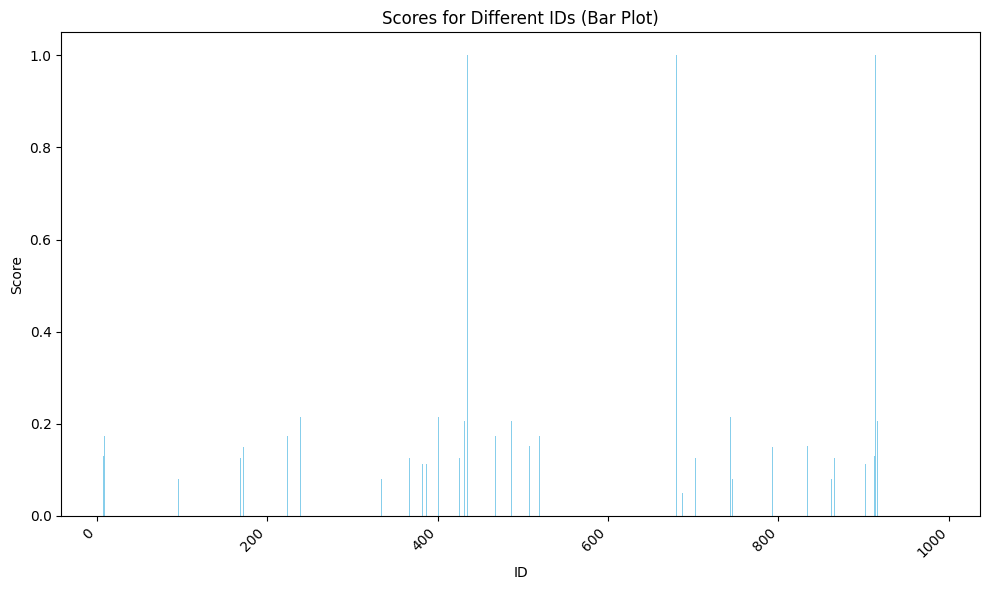

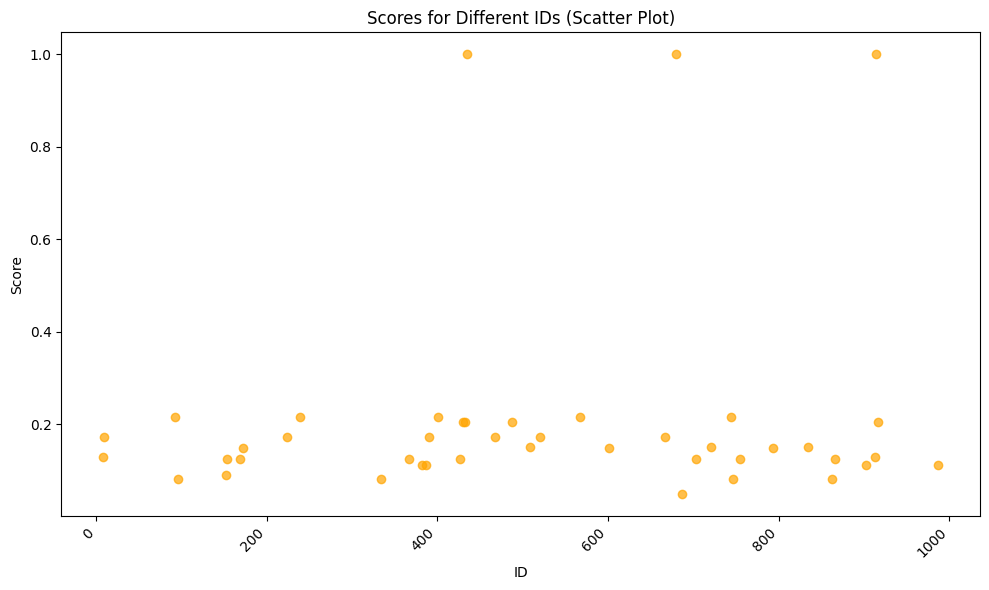

In [46]:
import matplotlib.pyplot as plt

# Extract IDs and scores from sorted recommendations
ids = [recommend[0] for recommend in sorted_recommendations]
scores = [recommend[1] for recommend in sorted_recommendations]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(ids, scores, color='skyblue')
plt.title('Scores for Different IDs (Bar Plot)')
plt.xlabel('ID')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ids, scores, color='orange', alpha=0.7)
plt.title('Scores for Different IDs (Scatter Plot)')
plt.xlabel('ID')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
